In [14]:
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import trt_pose.coco
import math
import os
import numpy as np
import traitlets
import pickle
import sys

sys.path.append("../")


In [15]:
from torch2trt import TRTModule
import torch
import trt_pose.models
with open('../preprocess/hand_pose.json', 'r') as f:
    hand_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(hand_pose)

num_parts = len(hand_pose['keypoints'])
num_links = len(hand_pose['skeleton'])

model = trt_pose.models.resnet18_baseline_att(
    num_parts, 2 * num_links).cuda().eval()


WIDTH = 256
HEIGHT = 256
MODEL_WEIGHTS = '../model/hand_pose_resnet18_att_244_244.pt'
OPTIMIZED_MODEL = '../model/hand_pose_resnet18_att_244_244.trt'
data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()

if not os.path.exists(OPTIMIZED_MODEL):
    model.load_state_dict(torch.load(MODEL_WEIGHTS))
    import torch2trt
    model_trt = torch2trt.torch2trt(
        model, [data], fp16_mode=True, max_workspace_size=1 << 25)
    torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)


model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))


/home/tbaderts/miniconda3/envs/nvidia/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/tbaderts/miniconda3/envs/nvidia/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [16]:
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

parse_objects = ParseObjects(
    topology, cmap_threshold=0.12, link_threshold=0.15)
draw_objects = DrawObjects(topology)


In [17]:

import torchvision.transforms as transforms
import PIL.Image

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')


def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]


In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))


In [19]:
from preprocessdata import preprocessdata
preprocessdata = preprocessdata(topology, num_parts)


In [20]:
from dataloader import dataloader
path = "/home/tbaderts/data/ost/ml_project/mvp/hand_dataset/"
label_file = "hand_dataset.json"
test_label = "hand_dataset_test.json"
hand = dataloader(path, label_file, test_label)


In [21]:
def data_preprocess(images):
    dist_bn_joints_all_data = []
    for im in images:
        im = im[:, ::-1, :]
        data_im = preprocess(im)
        cmap, paf = model_trt(data_im)
        cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
        counts, objects, peaks = parse_objects(cmap, paf)
        joints = preprocessdata.joints_inference(im, counts, objects, peaks)
        dist_bn_joints = preprocessdata.find_distance(joints)
        dist_bn_joints_all_data.append(dist_bn_joints)
    return dist_bn_joints_all_data


In [22]:
def smaller_dataset(dataset, no_samples_per_class, no_of_classes):
    total_samples_per_class = 100
    start = 0
    end = no_samples_per_class
    new_dataset = []
    labels = []
    for i in range(no_of_classes):
        new_data = dataset[start:end]
        start = start+total_samples_per_class
        end = start+no_samples_per_class
        new_dataset.extend(new_data)
        labels.extend([i+1]*no_samples_per_class)
    return new_dataset, labels


In [23]:
train_images, labels_train = hand.smaller_dataset(hand.train_images, 100, 6)


In [24]:
joints_train = data_preprocess(hand.train_images)
joints_test = data_preprocess(hand.test_images)


In [26]:
svm_train = True
if svm_train:
    clf, predicted = preprocessdata.trainsvm(
        clf, joints_train, joints_test, hand.labels_train, hand.labels_test)
    filename = '../model/svmmodel_new.sav'
    pickle.dump(clf, open(filename, 'wb'))
else:
    filename = '../model/svmmodel.sav'
    clf = pickle.load(open(filename, 'rb'))


In [27]:
preprocessdata.svm_accuracy(clf.predict(joints_test), hand.labels_test)


0.7571428571428571

/home/tbaderts/miniconda3/envs/nvidia/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


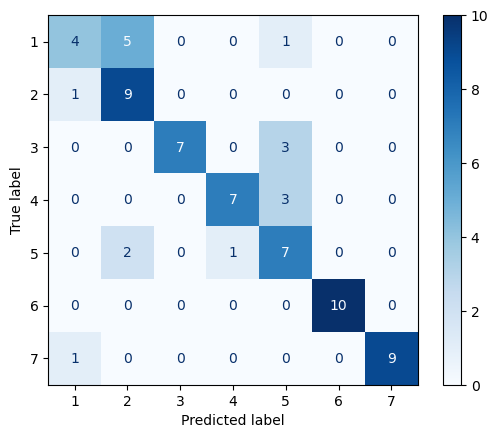

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

confusion_matrix(hand.labels_test, clf.predict(joints_test))
plot_confusion_matrix(clf, joints_test, hand.labels_test, cmap=plt.cm.Blues)
plt.show()

In [33]:
from sklearn.metrics import classification_report

print(classification_report(hand.labels_test, clf.predict(joints_test)))

              precision    recall  f1-score   support

           1       0.67      0.40      0.50        10
           2       0.56      0.90      0.69        10
           3       1.00      0.70      0.82        10
           4       0.88      0.70      0.78        10
           5       0.50      0.70      0.58        10
           6       1.00      1.00      1.00        10
           7       1.00      0.90      0.95        10

    accuracy                           0.76        70
   macro avg       0.80      0.76      0.76        70
weighted avg       0.80      0.76      0.76        70



In [28]:
clf.predict([joints_test[40], [0]*num_parts*num_parts])


array([2, 2])

In [29]:
clf.predict(joints_test)


array([2, 1, 1, 5, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 3,
       5, 5, 3, 3, 3, 3, 5, 3, 4, 4, 5, 4, 5, 4, 4, 4, 5, 4, 2, 5, 5, 5,
       5, 2, 5, 5, 5, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 1,
       7, 7, 7, 7])